## HR

### Import Tools

In [1]:
import numpy as np 
import pandas as pd 
from patsy import dmatrices 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn import metrics
import matplotlib.pyplot as plt 

### Load Data

In [12]:
data = pd.read_csv("../Data/HR_Left/HR_comma_sep.csv")
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Check Data Types

In [13]:
data.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

### Relationships

#### Salary

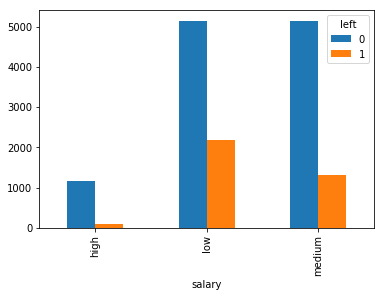

In [14]:
pd.crosstab(data.salary, data.left).plot(kind='bar')
plt.show()

#### Salary: Ratio

left       0     1
salary            
high    1155    82
low     5144  2172
medium  5129  1317
salary
high      1237
low       7316
medium    6446
dtype: int64


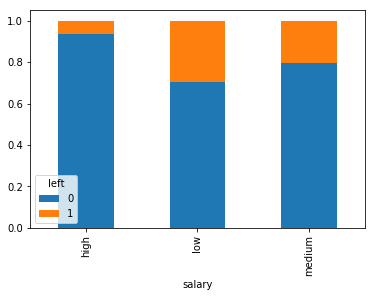

In [16]:
q = pd.crosstab(data.salary, data.left)
print(q)
print(q.sum(1))
q.div(q.sum(1), axis = 0).plot(kind='bar', stacked = True)
plt.show()

#### Satisfaction Level: Histgram

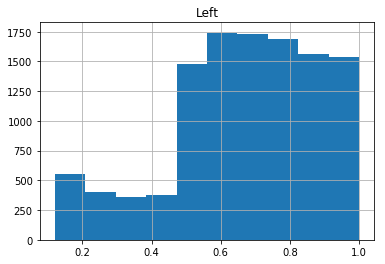

In [19]:
data[data.left==0].satisfaction_level.hist()
plt.title('Stayed')
plt.show()

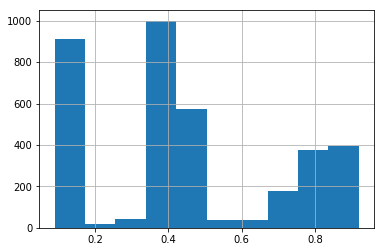

In [18]:
data[data.left==1].satisfaction_level.hist()
plt.title('Left')
plt.show()

### One-hot Encoding

In [20]:
model = LogisticRegression()
y, X = dmatrices('left~satisfaction_level+last_evaluation+number_project+average_montly_hours+time_spend_company+Work_accident+promotion_last_5years+C(sales)+C(salary)', data, return_type='dataframe')
X = X.rename(columns = {
    'C(sales)[T.RandD]': 'Department: Random',
    'C(sales)[T.accounting]': 'Department: Accounting',
    'C(sales)[T.hr]': 'Department: HR',
    'C(sales)[T.management]': 'Department: Management',
    'C(sales)[T.marketing]': 'Department: Marketing',
    'C(sales)[T.product_mng]': 'Department: Product_Management',
    'C(sales)[T.sales]': 'Department: Sales',
    'C(sales)[T.support]': 'Department: Support',
    'C(sales)[T.technical]': 'Department: Technical',
    'C(salary)[T.low]': 'Salary: Low',
    'C(salary)[T.medium]': 'Salary: Medium'}) 
y = np.ravel(y) 

### Influence Coeficient

In [22]:
model.fit(X, y)
pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))))

,0,1
0,Intercept,[-0.68682172395017]
1,Department: Random,[-0.489762967624363]
2,Department: Accounting,[0.09539255759733122]
3,Department: HR,[0.3286714969125059]
4,Department: Management,[-0.40109702117612267]
5,Department: Marketing,[0.08974406474405866]
6,Department: Product_Management,[-0.04095296254076212]
7,Department: Sales,[0.07497090979898711]
8,Department: Support,[0.1683601892896718]
9,Department: Technical,[0.17302139005293052]


### Model Score

In [23]:
print(model.score(X,y))

0.793652910194013


## Test

#### Satisfaction level: 0.5 Eval: 0.7 Projects: 4 Hours/Month: 160 Stayed: 3 years No promotion No accident

In [24]:
model.predict_proba([[1,0,0,1,0,0,0,0,0,0,0,0, 0.5, 0.7, 4.0, 160, 3.0, 0, 0]])

array([[0.91615561, 0.08384439]])

In [25]:
pred = model.predict(X)
(abs(pred-y)).sum() / len(y)

0.20634708980598707

### Split Data into Train and Test

In [26]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(Xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Score on Testing Set

In [28]:
model2 = LogisticRegression(C=10000)
model2.fit(Xtrain, ytrain)
pred = model2.predict(Xtest)
metrics.accuracy_score(ytest, pred)

0.7917777777777778

### Confusion Matrix

In [29]:
metrics.confusion_matrix(ytest, pred)
#        prediction
#
#
#actual
#
#
#

array([[3199,  263],
       [ 674,  364]])

### Classification Report

In [31]:
print(metrics.classification_report(ytest, pred))

             precision    recall  f1-score   support

        0.0       0.83      0.92      0.87      3462
        1.0       0.58      0.35      0.44      1038

avg / total       0.77      0.79      0.77      4500



### 10-Fold Cross Validation

In [32]:
print(cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10))

[0.80746169 0.792      0.79533333 0.78733333 0.804      0.804
 0.794      0.79       0.74449633 0.73582388]
